Binary 6/6 (MT + NU) B)

mRNA localization using binary classification (mitochondria/nucleus) (part 2): basic model with: <br> 
<br>
a) Method 1: no feature selection and <br>
b) Method 4: with feature importance-based feature selection (get_feature_importance type (default) =  EFstrType.FeatureImportance), threshold 0 <br>
c) Method 5: with feature importance-based feature selection (feature importance type: SHAP values), threshold > 0

In [1]:
import pandas as pd
from catboost import CatBoostClassifier
from catboost import Pool
import matplotlib.pyplot as plt
import numpy as np
import shap

In [2]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score, roc_auc_score, precision_recall_curve, roc_curve, auc, f1_score, classification_report

In [3]:
#data initialization

#Mitochondria (label = 2)
MT_train = pd.read_csv("../../Data/InputData/MT_iLearnfeatvalues_train_CSV.csv")
MT_test = pd.read_csv("../../Data/InputData/MT_iLearnfeatvalues_test_CSV.csv")

#Nucleus (label = 3)
NU_train = pd.read_csv("../../Data/InputData/NU_iLearnfeatvalues_train_CSV.csv")
NU_test = pd.read_csv("../../Data/InputData/NU_iLearnfeatvalues_test_CSV.csv")


print("MT TRAIN, TEST SHAPE:", MT_train.shape, ",", MT_test.shape)
print("NU TRAIN, TEST SHAPE:", NU_train.shape, ",", NU_test.shape)

MT TRAIN, TEST SHAPE: (280, 1026) , (70, 1026)
NU TRAIN, TEST SHAPE: (640, 1026) , (160, 1026)


In [4]:
###### NEXT STEP #######
#Merge training files for binary classification (CP+ER, CP+MT, CP+NU, ER+MT, ER+NU, MT+NU)
#Merge testing files same way

#How to merge: 
# - https://saturncloud.io/blog/how-to-merge-two-csv-files-into-one-with-pandas-by-id/
# or pd.concat


In [5]:

#Group 6: MT + NU

frames_MN_tra =[MT_train, NU_train]
frames_MN_tes =[MT_test, NU_test]

MT_NU_train = pd.concat(frames_MN_tra)
MT_NU_test = pd.concat(frames_MN_tes)

In [6]:

print("\nMT + NU TRAIN, TEST SHAPE:", MT_NU_train.shape, ",", MT_NU_test.shape)


MT + NU TRAIN, TEST SHAPE: (920, 1026) , (230, 1026)


In [7]:
MT_NU_test.head(73)

,#,label,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,mRNALoc_18808#856050|2|testing,2,0.001747,0.001747,0.005240,0.005240,0.001747,0.000873,0.002620,0.001747,...,0.000873,0.001747,0.001747,0.001747,0.001747,0.001747,0.001747,0.000873,0.001747,0.003493
1,mRNALoc_18516#852314|2|testing,2,0.010536,0.004390,0.004390,0.006146,0.003512,0.001756,0.000878,0.001756,...,0.000000,0.002634,0.003512,0.000878,0.003512,0.000878,0.001756,0.002634,0.004390,0.000000
2,mRNALoc_18612#853304|2|testing,2,0.004390,0.001756,0.002634,0.001756,0.003512,0.001756,0.000000,0.001756,...,0.000000,0.000000,0.002634,0.001756,0.000878,0.000000,0.005268,0.000878,0.002634,0.009658
3,mRNALoc_18679#854170|2|testing,2,0.001765,0.003530,0.002648,0.000000,0.001765,0.000883,0.000000,0.002648,...,0.000883,0.000000,0.000000,0.000883,0.001765,0.001765,0.002648,0.002648,0.000883,0.000883
4,mRNALoc_18546#852637|2|testing,2,0.000000,0.000887,0.001775,0.000000,0.001775,0.002662,0.000887,0.000000,...,0.002662,0.000887,0.002662,0.000887,0.004437,0.000887,0.002662,0.004437,0.002662,0.002662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,mRNALoc_18370#850602|2|testing,2,0.007919,0.003394,0.007919,0.002262,0.007919,0.003394,0.000000,0.004525,...,0.001131,0.001131,0.000000,0.000000,0.005656,0.001131,0.002262,0.002262,0.001131,0.002262
69,mRNALoc_18476#851819|2|testing,2,0.010181,0.003394,0.005656,0.001131,0.002262,0.003394,0.000000,0.001131,...,0.001131,0.004525,0.003394,0.002262,0.001131,0.001131,0.001131,0.001131,0.003394,0.003394
0,mRNALoc_4836#21374|3|testing,3,0.001632,0.002176,0.001632,0.002176,0.001632,0.001088,0.000544,0.001088,...,0.000000,0.004353,0.000544,0.000544,0.001632,0.002176,0.003264,0.002720,0.002720,0.004897
1,mRNALoc_7063#26002|3|testing,3,0.002176,0.001088,0.003264,0.000544,0.001088,0.000544,0.000000,0.001088,...,0.000544,0.001632,0.001088,0.002176,0.001088,0.000000,0.001088,0.001088,0.001088,0.000544


In [8]:
#FOR MT+NU
noname_MN_train = MT_NU_train.drop("#", axis="columns")
noname_MN_test = MT_NU_test.drop("#", axis="columns")


MT_NU_X_train = noname_MN_train.drop("label", axis="columns")
MT_NU_y_train = noname_MN_train["label"]

MT_NU_X_test = noname_MN_test.drop("label", axis="columns")
MT_NU_y_test = noname_MN_test["label"]

print("MT + NU X train:", MT_NU_X_train.shape)
print("MT + NU y train:", MT_NU_y_train.shape)
print("MT + NU X test:", MT_NU_X_test.shape)
print("MT + NU y test:", MT_NU_y_test.shape)

MT + NU X train: (920, 1024)
MT + NU y train: (920,)
MT + NU X test: (230, 1024)
MT + NU y test: (230,)


In [9]:
# Create data pools for feature importance/selection for MT + NU

MN_feature_names = list(MT_NU_X_train.columns)
print("Number of features:", len(MN_feature_names))

MN_train_pool = Pool(MT_NU_X_train, MT_NU_y_train, feature_names=MN_feature_names)

MN_test_pool = Pool(MT_NU_X_test, MT_NU_y_test)

print("*Mitochondria, Nucleus Pools created")

Number of features: 1024
*Mitochondria, Nucleus Pools created


    Method 1: Initial classification (without feature importance, selection or auto_class_weights)

In [10]:
MN_binary_model = CatBoostClassifier(loss_function="MultiClass")

In [11]:
#Fit model to MN data

MN_binary_model.fit(MN_train_pool)

Learning rate set to 0.078791
0:	learn: 0.6453486	total: 190ms	remaining: 3m 10s
1:	learn: 0.5967207	total: 336ms	remaining: 2m 47s
2:	learn: 0.5594406	total: 531ms	remaining: 2m 56s
3:	learn: 0.5220241	total: 702ms	remaining: 2m 54s
4:	learn: 0.4861558	total: 833ms	remaining: 2m 45s
5:	learn: 0.4591905	total: 966ms	remaining: 2m 40s
6:	learn: 0.4324965	total: 1.09s	remaining: 2m 35s
7:	learn: 0.4082558	total: 1.23s	remaining: 2m 32s
8:	learn: 0.3840052	total: 1.36s	remaining: 2m 30s
9:	learn: 0.3617618	total: 1.5s	remaining: 2m 28s
10:	learn: 0.3416231	total: 1.62s	remaining: 2m 25s
11:	learn: 0.3234066	total: 1.75s	remaining: 2m 24s
12:	learn: 0.3071336	total: 1.88s	remaining: 2m 22s
13:	learn: 0.2922344	total: 2s	remaining: 2m 20s
14:	learn: 0.2772289	total: 2.13s	remaining: 2m 19s
15:	learn: 0.2645473	total: 2.25s	remaining: 2m 18s
16:	learn: 0.2521766	total: 2.37s	remaining: 2m 17s
17:	learn: 0.2410430	total: 2.5s	remaining: 2m 16s
18:	learn: 0.2314290	total: 2.62s	remaining: 2m 1

In [12]:
#Check parameters used in this model fit

MN_bin_params = MN_binary_model.get_all_params()
print("Basic model parameters:", MN_bin_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [2, 3], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'learning_rate': 0.07879099994897842,

In [13]:
#Prediction using X_test
MN_y_pred = MN_binary_model.predict(MT_NU_X_test)

#Predication probability

MN_y_prob = MN_binary_model.predict_proba(MT_NU_X_test)

In [14]:
# Calculate F1 score and get classification report

print("Model 1: Basic model - Mitochondria & nucleus")

MN_cr = classification_report(MT_NU_y_test, MN_y_pred, digits=3)
print(MN_cr)

print('Accuracy score: ', accuracy_score(MT_NU_y_test, MN_y_pred))

MN_f1 = f1_score(MT_NU_y_test, MN_y_pred, average='macro')
print(f"\nF1 Score: {MN_f1}")
# print('Roc auc score : ', roc_auc_score(MT_NU_y_test, MN_y_prob))

Model 1: Basic model - Mitochondria & nucleus
              precision    recall  f1-score   support

           2      0.707     1.000     0.828        70
           3      1.000     0.819     0.900       160

    accuracy                          0.874       230
   macro avg      0.854     0.909     0.864       230
weighted avg      0.911     0.874     0.878       230

Accuracy score:  0.8739130434782608

F1 Score: 0.8643730047377944


In [15]:
# Confusion matrix for selected data

print("real values shape:", MT_NU_y_test.shape)
print("prediction shape:", MN_y_pred.shape)

MN_y_pred_fl = MN_y_pred
print("flattened prediction values shape:", MN_y_pred_fl.ravel().shape, "\n")

MN_cMatrix = confusion_matrix(MT_NU_y_test, MN_y_pred_fl)
print(MN_cMatrix)

real values shape: (230,)
prediction shape: (230, 1)
flattened prediction values shape: (230,) 

[[ 70   0]
 [ 29 131]]


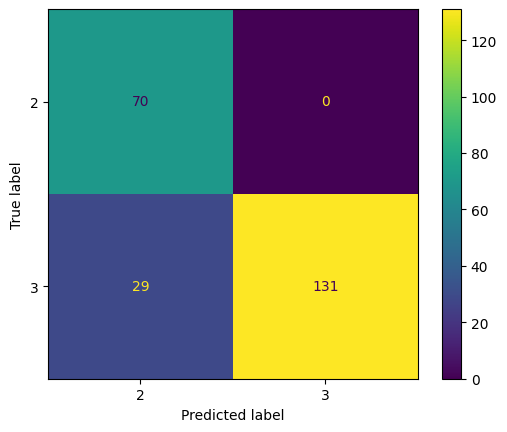

In [16]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=MN_cMatrix, display_labels=MN_binary_model.classes_)
disp.plot()
plt.show()

    Method 4: Feature importance-based feature selection with threshold > 0

In [17]:
#Feature importances for CM pair

MN_feat_importances = MN_binary_model.get_feature_importance(prettified=True)
MN_feat_importances.head(100)

,Feature Id,Importances
0,CAGCT,6.920010
1,CCCCC,5.294068
2,TATCG,5.011204
3,CGGTA,3.013808
4,AGCAG,2.661691
...,...,...
95,CGGTC,0.175875
96,CGTGG,0.174687
97,AAGAT,0.174337
98,TGTCG,0.173563


In [18]:
# Show only feature importances above 0

threshold_chosen_features = MN_feat_importances[MN_feat_importances['Importances'] > 0]
num_chosen_features = len(threshold_chosen_features)

print(threshold_chosen_features)

print("\nAmount of features with importnace above 0 (selected features):", num_chosen_features)

    Feature Id   Importances
0        CAGCT  6.920010e+00
1        CCCCC  5.294068e+00
2        TATCG  5.011204e+00
3        CGGTA  3.013808e+00
4        AGCAG  2.661691e+00
..         ...           ...
766      GCTCC  9.612168e-06
767      ACTCA  7.298940e-06
768      CAATG  7.166439e-06
769      ACCGC  3.639255e-06
770      TCGCG  5.868738e-07

[771 rows x 2 columns]

Amount of features with importnace above 0 (selected features): 771


In [19]:
print("Sum of total feature importances: ", sum(MN_feat_importances.Importances))
print("Sum of feature importances > 0: ", sum(threshold_chosen_features.Importances))

Sum of total feature importances:  99.99999999999989
Sum of feature importances > 0:  99.99999999999989


In [21]:
# Select features with importance values above 0

MN_selected_feat = MN_feat_importances[:num_chosen_features]['Feature Id'].tolist()

# print(MN_selected_feat)

In [22]:
MT_NU_X_train.shape

(920, 1024)

In [23]:
# See original training set

MT_NU_X_train.head(283)


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.003945,0.001255,0.002690,0.002152,0.001435,0.000359,0.001076,0.001435,0.001973,0.001435,...,0.001614,0.001255,0.003407,0.001435,0.001435,0.001973,0.001435,0.001435,0.002869,0.001435
1,0.006502,0.002956,0.001970,0.003941,0.004138,0.001576,0.001379,0.001379,0.002562,0.001970,...,0.000591,0.001970,0.001576,0.000394,0.001773,0.001773,0.004729,0.003350,0.002365,0.014778
2,0.010090,0.001682,0.003784,0.002943,0.001892,0.001892,0.000420,0.001472,0.003153,0.002523,...,0.000210,0.002312,0.000841,0.001472,0.001892,0.001682,0.001051,0.002102,0.000841,0.003153
3,0.002139,0.001528,0.002139,0.003362,0.001528,0.001222,0.000917,0.001528,0.003056,0.001528,...,0.000917,0.001222,0.003667,0.002751,0.002139,0.002751,0.000306,0.002751,0.002751,0.002445
4,0.001737,0.000000,0.000579,0.002895,0.000579,0.000000,0.000000,0.002895,0.002316,0.001158,...,0.002895,0.005790,0.002316,0.001737,0.002895,0.004632,0.002316,0.005211,0.002895,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,0.004355,0.000871,0.003484,0.005226,0.003484,0.000000,0.000000,0.000871,0.006098,0.003484,...,0.001742,0.004355,0.003484,0.002613,0.000000,0.002613,0.002613,0.006098,0.003484,0.007840
279,0.011354,0.001747,0.004367,0.006114,0.003493,0.000873,0.000873,0.001747,0.005240,0.002620,...,0.000000,0.000873,0.003493,0.000873,0.000873,0.000873,0.001747,0.000873,0.001747,0.003493
0,0.006391,0.001389,0.003334,0.001111,0.001389,0.000834,0.000556,0.000556,0.003056,0.000556,...,0.000000,0.000556,0.001389,0.000278,0.001389,0.001111,0.001111,0.000556,0.001945,0.005835
1,0.000000,0.000000,0.000000,0.001450,0.000000,0.000725,0.000000,0.000000,0.000725,0.000000,...,0.000000,0.000725,0.003626,0.001450,0.001450,0.000725,0.000725,0.000725,0.001450,0.000000


In [24]:
#Create training set with selected features 

MN_X_train_selected = MT_NU_X_train[MN_selected_feat]
MN_X_train_selected.head()

,CAGCT,CCCCC,TATCG,CGGTA,AGCAG,TCCAA,CAGCA,TCAGC,ACGTT,CGTTA,...,TTTAG,GGGCT,TCCCG,TAATA,TGCGG,GCTCC,ACTCA,CAATG,ACCGC,TCGCG
0,0.001076,0.00000,0.000717,0.000359,0.001435,0.000897,0.002152,0.000897,0.000717,0.000717,...,0.001255,0.001076,0.000000,0.000538,0.000538,0.000359,0.000538,0.000717,0.001076,0.000179
1,0.000788,0.00197,0.000394,0.000788,0.003350,0.002759,0.003153,0.000788,0.000788,0.000985,...,0.001970,0.000788,0.000197,0.000985,0.000000,0.001379,0.001773,0.001773,0.000591,0.000000
2,0.001051,0.00021,0.001051,0.000000,0.002312,0.002523,0.001472,0.001472,0.001261,0.000420,...,0.000420,0.001682,0.000631,0.000420,0.000420,0.001051,0.001472,0.000420,0.000210,0.000210
3,0.000306,0.00000,0.000611,0.000917,0.000917,0.001222,0.000611,0.000306,0.001528,0.000917,...,0.001834,0.000611,0.000306,0.000917,0.000306,0.000306,0.001222,0.003667,0.000611,0.000306
4,0.001737,0.00000,0.000579,0.002316,0.000579,0.005211,0.000579,0.000579,0.002316,0.001158,...,0.002895,0.001737,0.000000,0.000579,0.000000,0.000579,0.000000,0.000579,0.000000,0.000000


In [25]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(MN_X_train_selected.columns) == MN_selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [26]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", MN_X_train_selected.shape)
print("Shape of y_train (number of labels):", MT_NU_y_train.shape)

Shape of X_train_selected (number of variables/sequences): (920, 771)
Shape of y_train (number of labels): (920,)


In [27]:
# Create pool object for selected feature data
print("Original number of features:", len(MN_feature_names), "\n Number of selected features:", len(MN_selected_feat))

MN_selected_train_pool = Pool(MN_X_train_selected, MT_NU_y_train, feature_names=MN_selected_feat)

Original number of features: 1024 
 Number of selected features: 771


In [28]:
#Create new model for data with selected features
MN_FIFS_model = CatBoostClassifier(loss_function="MultiClass")

# Fit new data into same model as before

MN_FIFS_model.fit(MN_selected_train_pool)

Learning rate set to 0.078791
0:	learn: 0.6508668	total: 118ms	remaining: 1m 58s
1:	learn: 0.6025034	total: 217ms	remaining: 1m 48s
2:	learn: 0.5622492	total: 324ms	remaining: 1m 47s
3:	learn: 0.5243000	total: 416ms	remaining: 1m 43s
4:	learn: 0.4899149	total: 520ms	remaining: 1m 43s
5:	learn: 0.4629656	total: 619ms	remaining: 1m 42s
6:	learn: 0.4362852	total: 738ms	remaining: 1m 44s
7:	learn: 0.4118932	total: 859ms	remaining: 1m 46s
8:	learn: 0.3874056	total: 983ms	remaining: 1m 48s
9:	learn: 0.3644666	total: 1.1s	remaining: 1m 49s
10:	learn: 0.3452013	total: 1.21s	remaining: 1m 49s
11:	learn: 0.3284670	total: 1.32s	remaining: 1m 48s
12:	learn: 0.3118839	total: 1.41s	remaining: 1m 47s
13:	learn: 0.2957350	total: 1.54s	remaining: 1m 48s
14:	learn: 0.2811573	total: 1.65s	remaining: 1m 48s
15:	learn: 0.2672157	total: 1.76s	remaining: 1m 48s
16:	learn: 0.2535993	total: 1.88s	remaining: 1m 48s
17:	learn: 0.2421152	total: 2s	remaining: 1m 49s
18:	learn: 0.2312356	total: 2.12s	remaining: 1m 

In [29]:
#Prediction using X_test only for selected features data
MN_FIFS_y_pred = MN_FIFS_model.predict(MT_NU_X_test)

#Predication probability for selected features data

MN_FIFS_y_prob = MN_FIFS_model.predict_proba(MT_NU_X_test)

In [30]:
# Calculate F1 score and get classification report

print("Model 4: Feature selection (PredictionValuesChange) w/ threshold > 0 - Mitochondria & nucleus")

print("Number of chosen features:", num_chosen_features, "\n")

MN_FIFS_cr = classification_report(MT_NU_y_test, MN_FIFS_y_pred, digits=3)
print(MN_FIFS_cr)

print('Accuracy score: ', accuracy_score(MT_NU_y_test, MN_FIFS_y_pred))

MN_FIFS_f1 = f1_score(MT_NU_y_test, MN_FIFS_y_pred, average='macro')
print(f"\nF1 Score: {MN_FIFS_f1}")

# print('Roc auc score : ', roc_auc_score(MT_NU_y_test, MN_FIFS_y_prob))

Model 4: Feature selection (PredictionValuesChange) w/ threshold > 0 - Mitochondria & nucleus
Number of chosen features: 771 

              precision    recall  f1-score   support

           2      0.714     1.000     0.833        70
           3      1.000     0.825     0.904       160

    accuracy                          0.878       230
   macro avg      0.857     0.912     0.869       230
weighted avg      0.913     0.878     0.883       230

Accuracy score:  0.8782608695652174

F1 Score: 0.8687214611872145


In [31]:
# Confusion matrix for selected data

print("real values shape:", MT_NU_y_test.shape)
print("prediction shape:", MN_FIFS_y_pred.shape)

MN_FIFS_y_pred_fl = MN_FIFS_y_pred
print("flattened prediction values shape:", MN_FIFS_y_pred_fl.ravel().shape, "\n")

MN_FIFS_cMatrix = confusion_matrix(MT_NU_y_test, MN_FIFS_y_pred_fl)
print(MN_FIFS_cMatrix)

real values shape: (230,)
prediction shape: (230, 1)
flattened prediction values shape: (230,) 

[[ 70   0]
 [ 28 132]]


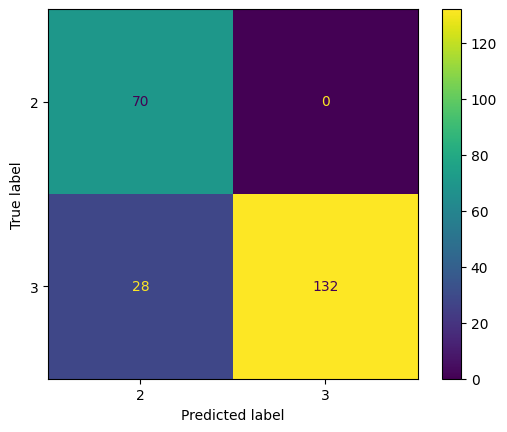

In [32]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=MN_FIFS_cMatrix, display_labels=MN_FIFS_model.classes_)
disp.plot()
plt.show()

**************

    Method 5: Modelling using feature selection based on feature importance values (SHAP Values) with threshold > 0

In [33]:
#SHAP explainer to explain CatBoost output
explainer = shap.TreeExplainer(MN_binary_model)

In [34]:
#SHAP values for X_train
MN_shap_values = explainer.shap_values(MT_NU_X_train)

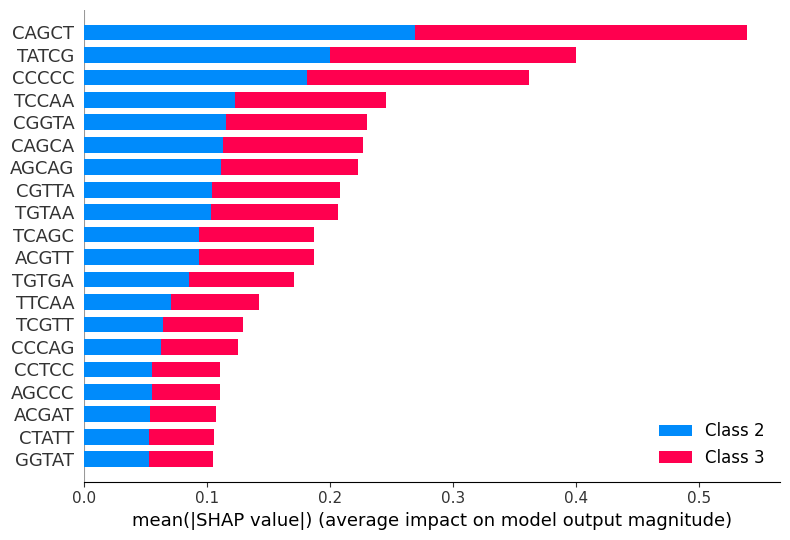

In [35]:
shap.summary_plot(MN_shap_values, MT_NU_X_train, plot_size=0.2, class_names=["Class 2", "Class 3"])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


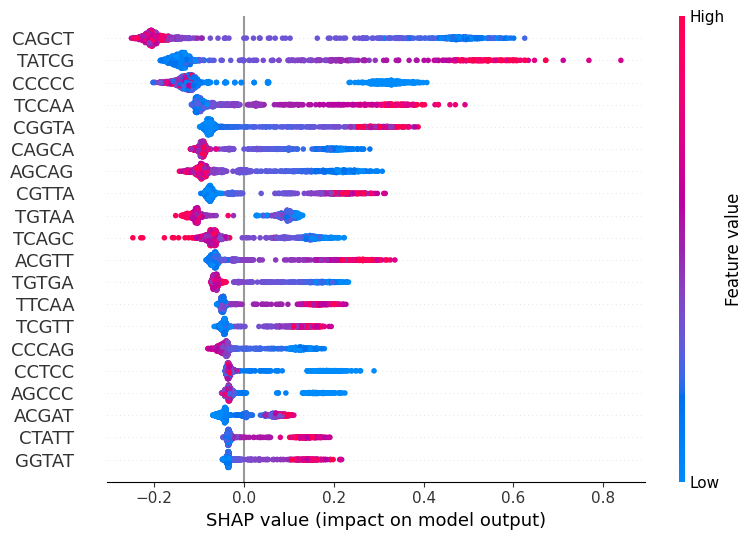

In [36]:
# Summary shap bar plot of Cytoplasm class (class 0)
shap.summary_plot(MN_shap_values[0], MT_NU_X_train, plot_size=0.2)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


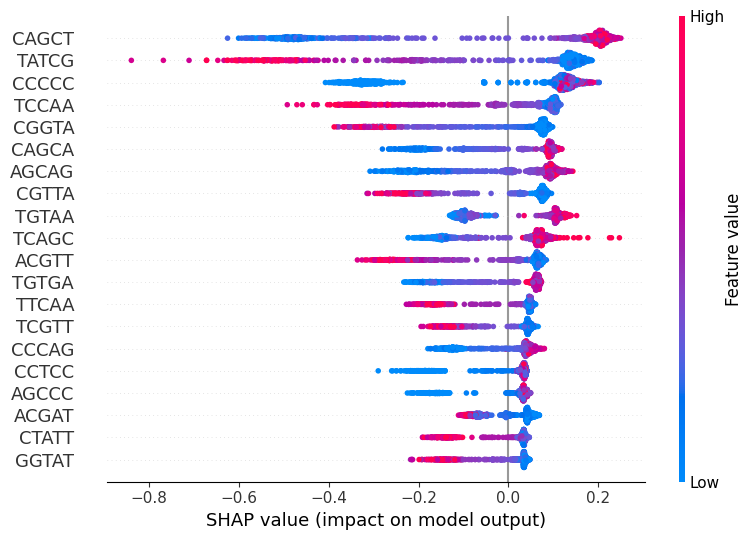

In [37]:
# Summary shap bar plot of Endoplasmic reticuum class (class 1)
shap.summary_plot(MN_shap_values[1], MT_NU_X_train, plot_size=0.2)

In [38]:
#Put values one one class into dataframe to use as reference values for FS
shap_df = pd.DataFrame(MN_shap_values[0], columns=MT_NU_X_train.columns)


In [39]:
# Calculate feature importance by only taking the values which 
MN_shap_FI = (shap_df[shap_df>0]
                                .mean()
                                .sort_values(ascending=False)
                                .reset_index()
                                .rename(columns={'index':'Feature Id', 0:'Importances'})
                                # .head()
                        )

In [40]:
MN_shap_FI.head()

#### Check these feautre values with the features on shap plot for CP above #####
# Might need to use other method to get only features in with positive outcome + in red (those in red on right side):


,Feature Id,Importances
0,CAGCT,0.434662
1,TATCG,0.359942
2,CCCCC,0.310677
3,TTTTT,0.288863
4,CGGTA,0.238025


In [41]:
# shap.summary_plot(MN_shap_values[0], MT_NU_X_train, show=False, max_display=30, plot_size=0.2)

In [42]:
#Classifier results with MN_feature_importance

In [43]:
from numpy import nansum
print("Sum of all shap feature importance values:", nansum(MN_shap_FI["Importances"]))

Sum of all shap feature importance values: 10.119804222394428


In [59]:
# Show only feature importances above 0

MN_SHAP_thres_chosen = MN_shap_FI[MN_shap_FI['Importances'] > 0]
MN_shap_num_chosen = len(MN_SHAP_thres_chosen)

print(MN_SHAP_thres_chosen)

print("\nAmount of features with importance above 0 (selected features):", MN_shap_num_chosen)

    Feature Id   Importances
0        CAGCT  4.346615e-01
1        TATCG  3.599424e-01
2        CCCCC  3.106769e-01
3        TTTTT  2.888628e-01
4        CGGTA  2.380250e-01
..         ...           ...
766      TTTAG  8.862578e-06
767      TCCCG  6.563774e-06
768      ACCGC  4.219236e-06
769      GCTCC  2.399104e-06
770      TCGCG  8.257425e-07

[771 rows x 2 columns]

Amount of features with importance above 0 (selected features): 771


In [60]:
print("Sum of total feature importances: ", sum(MN_shap_FI.Importances))
print("Sum of feature importances > 0: ", sum(MN_SHAP_thres_chosen.Importances))

Sum of total feature importances:  nan
Sum of feature importances > 0:  10.119804222394457


In [61]:
# Select features with importance values above 0.1

MN_shap_selected_feat = MN_shap_FI[:MN_shap_num_chosen]['Feature Id'].tolist()

# print(MN_shap_selected_feat)

In [62]:
MT_NU_X_train.shape

(920, 1024)

In [63]:
# See original training set

MT_NU_X_train.head(826)


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.003945,0.001255,0.002690,0.002152,0.001435,0.000359,0.001076,0.001435,0.001973,0.001435,...,0.001614,0.001255,0.003407,0.001435,0.001435,0.001973,0.001435,0.001435,0.002869,0.001435
1,0.006502,0.002956,0.001970,0.003941,0.004138,0.001576,0.001379,0.001379,0.002562,0.001970,...,0.000591,0.001970,0.001576,0.000394,0.001773,0.001773,0.004729,0.003350,0.002365,0.014778
2,0.010090,0.001682,0.003784,0.002943,0.001892,0.001892,0.000420,0.001472,0.003153,0.002523,...,0.000210,0.002312,0.000841,0.001472,0.001892,0.001682,0.001051,0.002102,0.000841,0.003153
3,0.002139,0.001528,0.002139,0.003362,0.001528,0.001222,0.000917,0.001528,0.003056,0.001528,...,0.000917,0.001222,0.003667,0.002751,0.002139,0.002751,0.000306,0.002751,0.002751,0.002445
4,0.001737,0.000000,0.000579,0.002895,0.000579,0.000000,0.000000,0.002895,0.002316,0.001158,...,0.002895,0.005790,0.002316,0.001737,0.002895,0.004632,0.002316,0.005211,0.002895,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,0.006428,0.004326,0.004203,0.005562,0.005686,0.002349,0.000618,0.002101,0.003832,0.003214,...,0.000247,0.001607,0.001360,0.000742,0.000865,0.002225,0.001731,0.001112,0.001112,0.000618
542,0.004331,0.002475,0.002598,0.002970,0.002103,0.000619,0.000000,0.001732,0.002351,0.001237,...,0.000247,0.001361,0.002598,0.001980,0.001485,0.001609,0.002846,0.001361,0.002351,0.003464
543,0.005940,0.001237,0.002722,0.002970,0.001361,0.001732,0.000124,0.002104,0.002599,0.001980,...,0.000247,0.002475,0.000990,0.001361,0.002351,0.002351,0.001856,0.001609,0.002970,0.003217
544,0.002353,0.001734,0.001981,0.002353,0.001734,0.001362,0.000619,0.001362,0.003096,0.001238,...,0.000371,0.001238,0.001238,0.001114,0.001610,0.001610,0.001486,0.001486,0.001362,0.000743


In [64]:
#Create training set with selected features 

MN_X_train_shap_selected = MT_NU_X_train[MN_shap_selected_feat]
MN_X_train_shap_selected.head()

,CAGCT,TATCG,CCCCC,TTTTT,CGGTA,TCCAA,ACGTT,CGTTA,AGCAG,CCTCC,...,GGGCT,TAATA,ATCTT,ACTCA,TGCGG,TTTAG,TCCCG,ACCGC,GCTCC,TCGCG
0,0.001076,0.000717,0.00000,0.001435,0.000359,0.000897,0.000717,0.000717,0.001435,0.000000,...,0.001076,0.000538,0.001435,0.000538,0.000538,0.001255,0.000000,0.001076,0.000359,0.000179
1,0.000788,0.000394,0.00197,0.014778,0.000788,0.002759,0.000788,0.000985,0.003350,0.001576,...,0.000788,0.000985,0.001379,0.001773,0.000000,0.001970,0.000197,0.000591,0.001379,0.000000
2,0.001051,0.001051,0.00021,0.003153,0.000000,0.002523,0.001261,0.000420,0.002312,0.001051,...,0.001682,0.000420,0.001051,0.001472,0.000420,0.000420,0.000631,0.000210,0.001051,0.000210
3,0.000306,0.000611,0.00000,0.002445,0.000917,0.001222,0.001528,0.000917,0.000917,0.001528,...,0.000611,0.000917,0.001222,0.001222,0.000306,0.001834,0.000306,0.000611,0.000306,0.000306
4,0.001737,0.000579,0.00000,0.000000,0.002316,0.005211,0.002316,0.001158,0.000579,0.001158,...,0.001737,0.000579,0.000000,0.000000,0.000000,0.002895,0.000000,0.000000,0.000579,0.000000


In [65]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(MN_X_train_shap_selected.columns) == MN_shap_selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [66]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", MN_X_train_shap_selected.shape)
print("Shape of y_train (number of labels):", MT_NU_y_train.shape)

Shape of X_train_selected (number of variables/sequences): (920, 771)
Shape of y_train (number of labels): (920,)


In [52]:
# Create pool object for selected feature data
print("Original number of features:", len(MN_feature_names), "\n Number of selected features:", len(MN_shap_selected_feat))

MN_shap_selected_train_pool = Pool(MN_X_train_shap_selected, MT_NU_y_train, feature_names=MN_shap_selected_feat)

Original number of features: 1024 
 Number of selected features: 771


In [53]:
#Create new model for data with selected features
MN_FIFS_shap_model = CatBoostClassifier(loss_function="MultiClass")

# Fit new data into same model as before

MN_FIFS_shap_model.fit(MN_shap_selected_train_pool)

Learning rate set to 0.078791
0:	learn: 0.6449744	total: 108ms	remaining: 1m 48s
1:	learn: 0.6044701	total: 221ms	remaining: 1m 50s
2:	learn: 0.5668655	total: 320ms	remaining: 1m 46s
3:	learn: 0.5298686	total: 416ms	remaining: 1m 43s
4:	learn: 0.4960061	total: 521ms	remaining: 1m 43s
5:	learn: 0.4669481	total: 621ms	remaining: 1m 42s
6:	learn: 0.4413279	total: 717ms	remaining: 1m 41s
7:	learn: 0.4163593	total: 821ms	remaining: 1m 41s
8:	learn: 0.3916003	total: 915ms	remaining: 1m 40s
9:	learn: 0.3704554	total: 1.02s	remaining: 1m 40s
10:	learn: 0.3507528	total: 1.13s	remaining: 1m 41s
11:	learn: 0.3336334	total: 1.23s	remaining: 1m 41s
12:	learn: 0.3171768	total: 1.36s	remaining: 1m 43s
13:	learn: 0.3018602	total: 1.49s	remaining: 1m 44s
14:	learn: 0.2876763	total: 1.61s	remaining: 1m 45s
15:	learn: 0.2735427	total: 1.71s	remaining: 1m 45s
16:	learn: 0.2597407	total: 1.8s	remaining: 1m 44s
17:	learn: 0.2478983	total: 1.9s	remaining: 1m 43s
18:	learn: 0.2363168	total: 1.99s	remaining: 1

In [54]:
#Check parameters used in this model fit

MN_FIFS_shap_params = MN_FIFS_shap_model.get_all_params()
print("Basic model parameters:", MN_FIFS_shap_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [2, 3], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'learning_rate': 0.07879099994897842,

In [55]:
#Prediction using X_test only for selected features data
MN_FIFS_shap_y_pred = MN_FIFS_shap_model.predict(MT_NU_X_test)

#Predication probability for selected features data

MN_FIFS_shap_y_prob = MN_FIFS_shap_model.predict_proba(MT_NU_X_test)

In [56]:
# Calculate F1 score and get classification report

print("Model 5: Feature selection (SHAP) w/ threshold > 0 - Mitochondria & nucleus")

print("Number of chosen features:", len(MN_shap_selected_feat), "\n")

MN_FIFS_shap_cr = classification_report(MT_NU_y_test, MN_FIFS_shap_y_pred, digits=3)
print(MN_FIFS_shap_cr)

print('Accuracy score: ', accuracy_score(MT_NU_y_test, MN_FIFS_shap_y_pred))

MN_FIFS_shap_f1 = f1_score(MT_NU_y_test, MN_FIFS_shap_y_pred, average='macro')
print(f"\nF1 Score: {MN_FIFS_shap_f1}")
# print('Roc auc score : ', roc_auc_score(MT_NU_y_test, MN_FIFS_shap_y_prob))

Model 5: Feature selection (SHAP) w/ threshold > 0 - Mitochondria & nucleus
Number of chosen features: 771 

              precision    recall  f1-score   support

           2      0.722     1.000     0.838        70
           3      1.000     0.831     0.908       160

    accuracy                          0.883       230
   macro avg      0.861     0.916     0.873       230
weighted avg      0.915     0.883     0.887       230

Accuracy score:  0.8826086956521739

F1 Score: 0.8730865913224746


In [57]:
# Confusion matrix for selected data

print("real values shape:", MT_NU_y_test.shape)
print("prediction shape:", MN_FIFS_shap_y_pred.shape)

MN_FIFS_shap_y_pred_fl = MN_FIFS_shap_y_pred
print("flattened prediction values shape:", MN_FIFS_shap_y_pred_fl.ravel().shape, "\n")

MN_FIFS_shap_cMatrix = confusion_matrix(MT_NU_y_test, MN_FIFS_shap_y_pred_fl)
print(MN_FIFS_shap_cMatrix)

real values shape: (230,)
prediction shape: (230, 1)
flattened prediction values shape: (230,) 

[[ 70   0]
 [ 27 133]]


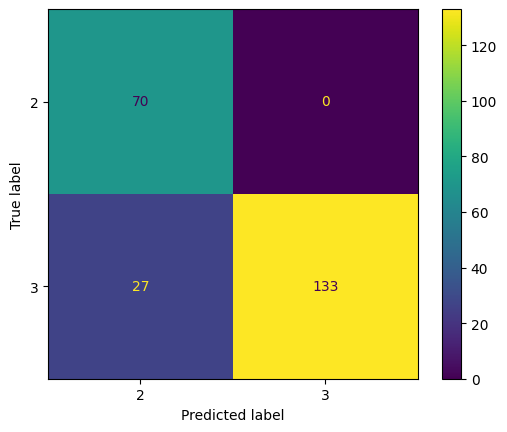

In [58]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=MN_FIFS_shap_cMatrix, display_labels=MN_FIFS_shap_model.classes_)
disp.plot()
plt.show()